In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/ResearchWork_2023/Single_disease/train_images.zip'
!unzip '/content/drive/MyDrive/ResearchWork_2023/Single_disease/test_images.zip'
!unzip '/content/drive/MyDrive/ResearchWork_2023/Single_disease/val_images.zip'

Archive:  /content/drive/MyDrive/ResearchWork_2023/Single_disease/train_images.zip
replace train_cropped_images/4689_right.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/ResearchWork_2023/Single_disease/test_images.zip
replace test_cropped_images/4999_right.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/ResearchWork_2023/Single_disease/val_images.zip
replace val_cropped_images/4761_right.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# Load the pre-trained Inception-ResNet-V2 model
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(299,299,3))

# Freeze the pre-trained weights
base_model.trainable = False

base_model.layers[-1].trainable = True

# Pass the input layer through the pre-trained model
features = base_model.output

outputs = tf.keras.layers.Flatten()(features)
outputs = tf.keras.layers.Dropout(0.5)(outputs)
outputs = tf.keras.layers.Dense(units=8, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(outputs)

In [ ]:
# !pip install tensorflow_addons
# import tensorflow_addons as tfa
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
# f1_score = tfa.metrics.F1Score(num_classes=8)
categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [ ]:

# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
# Compile the model
# base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
               loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[categorical_accuracy, precision , recall])

In [ ]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [ ]:

# Load the image data and one-hot encoded multi-label data
# Load the data from the excel sheet into a pandas dataframe
# Load both left and right eye dataset
base_path = '/content/drive/MyDrive/ResearchWork_2023/Single_disease'
train_df = pd.read_excel(f'{base_path}/train_undersampled_labels.xlsx')
test_df = pd.read_excel(f'{base_path}/test_labels.xlsx')
val_df = pd.read_excel(f'{base_path}/val_undersampled_labels.xlsx')


In [ ]:
train_df

,Unnamed: 0,Fundus,Diagnostic_Keywords,N,D,G,C,A,H,M,O
0,322,4678_left.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
1,408,4404_right.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
2,405,4374_right.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
3,462,1246_left.jpg,glaucoma,0,0,1,0,0,0,0,0
4,1509,1617_right.jpg,pathological myopia,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1747,1130,1091_right.jpg,dry age-related macular degeneration,0,0,0,0,1,0,0,0
1748,1294,144_left.jpg,pathological myopia,0,0,0,0,0,0,1,0
1749,860,2133_right.jpg,cataract,0,0,0,1,0,0,0,0
1750,1459,1549_right.jpg,pathological myopia,0,0,0,0,0,0,1,0


# Train

In [ ]:
# Split the data into two arrays, one for the image paths and one for the labels
train_images_base_path = '/content/train_cropped_images/'
image_paths = train_images_base_path + train_df["Fundus"].values
labels = train_df.iloc[:, 3:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
train_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# Test

In [ ]:

# Split the data into two arrays, one for the image paths and one for the labels
test_images_base_path = '/content/test_cropped_images/'
image_paths = test_images_base_path + test_df["Fundus"].values
labels = test_df.iloc[:, 5:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# Validation

In [ ]:
# Split the data into two arrays, one for the image paths and one for the labels
val_images_base_path = '/content/val_cropped_images/'
image_paths = val_images_base_path + val_df["Fundus"].values
labels = val_df.iloc[:, 3:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
val_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

In [ ]:
# Load the images and preprocess them
def load_and_preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])
    image = tf.keras.applications.vgg19.preprocess_input(image)
    return image, label

# Apply the load_and_preprocess_image function to the dataset
train_dataset = train_dataset.map(load_and_preprocess_image)
test_dataset = test_dataset.map(load_and_preprocess_image)
val_dataset = val_dataset.map(load_and_preprocess_image)

# Shuffle the data and batch it
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)

In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [ ]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [ ]:
# Train the model
history=model.fit(train_dataset, epochs=50, batch_size=batch_size, validation_data=val_dataset)

Epoch 1/50
55/55 [==============================] - 55s 759ms/step - loss: 30.6784 - categorical_accuracy: 0.1758 - precision: 0.1770 - recall: 0.1712 - val_loss: 24.7048 - val_categorical_accuracy: 0.2669 - val_precision: 0.2760 - val_recall: 0.2594
Epoch 2/50
55/55 [==============================] - 30s 497ms/step - loss: 28.5976 - categorical_accuracy: 0.2112 - precision: 0.2130 - recall: 0.2061 - val_loss: 23.3588 - val_categorical_accuracy: 0.3271 - val_precision: 0.3498 - val_recall: 0.3195
Epoch 3/50
55/55 [==============================] - 31s 512ms/step - loss: 26.8791 - categorical_accuracy: 0.2517 - precision: 0.2533 - recall: 0.2443 - val_loss: 22.3945 - val_categorical_accuracy: 0.3684 - val_precision: 0.3785 - val_recall: 0.3571
Epoch 4/50
55/55 [==============================] - 32s 494ms/step - loss: 25.6475 - categorical_accuracy: 0.2962 - precision: 0.2996 - recall: 0.2888 - val_loss: 21.5983 - val_categorical_accuracy: 0.3872 - val_precision: 0.3900 - val_recall: 0.3

In [ ]:
model.save('/content/drive/MyDrive/ResearchWork_2023/models/model_undersample.h5')

In [ ]:
import matplotlib.pyplot as plt

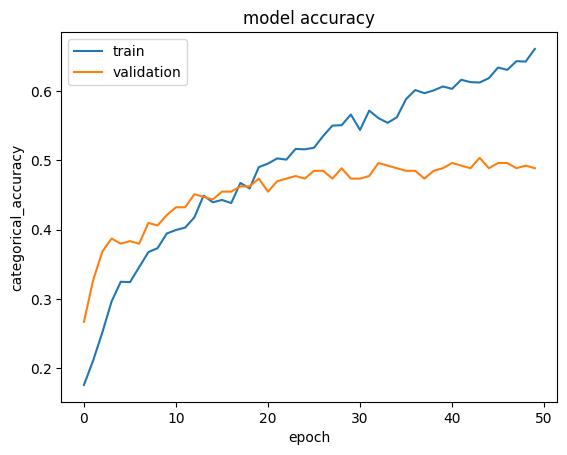

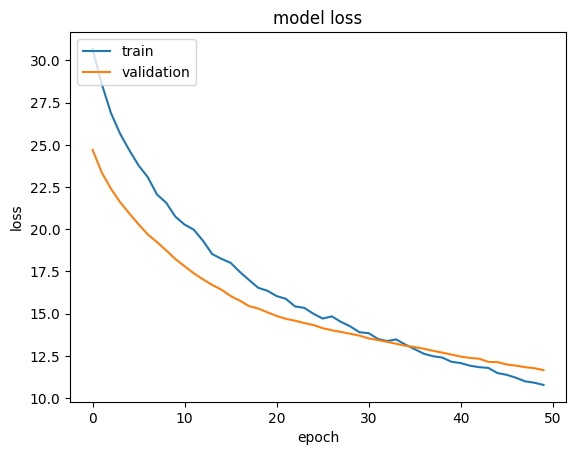

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
result = model.evaluate(test_dataset)
result

60/60 [==============================] - 30s 421ms/step - loss: 14.0029 - categorical_accuracy: 0.2577 - precision: 0.2597 - recall: 0.2439


[14.002908706665039,
 0.2576557695865631,
 0.25969645380973816,
 0.2439281940460205]

In [ ]:
load_model = tf.keras.saving.load_model('/content/drive/MyDrive/ResearchWork_2023/models/model_4.h5',compile=False)

In [ ]:
import numpy as np

# Assuming you have a test dataset 'test_data' with image tensors and corresponding labels
predictions = []
true_labels = []

# Iterate over the test dataset and make predictions
for images, labels in test_dataset:
    preds = model.predict(images)
    predictions.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))

# Compute the confusion matrix
cm = tf.math.confusion_matrix(true_labels, predictions)

# Convert the confusion matrix to a NumPy array and print it
print("Confusion Matrix:")
print(cm.numpy())


1/1 [==============================] - 0s 141ms/step
Confusion Matrix:
[[184 162 179  24 121  29  22  98]
 [ 35  47  15   4  33   7   3  34]
 [  9   3  36   6   6   2   0   3]
 [  0   1   3  76   0   0   0   1]
 [ 10  13  13   1  21   0   4   8]
 [  4   9   1   0   3   5   0   5]
 [  1   0   0   2   0   0  54   1]
 [ 74  96  61  34  96   7 163  65]]
